# Models
- MutinomialNB with TfidVectorizer
    - cleaned: accuracy - 0.65

    - cleaned and stemmed: accuracy - 0.69

    - cleaned and lemmized: accuracy - 0.70


- MutinomialNB with CountVectorizer
    - cleaned : accuracy - 0.80 (BEST MODEL)

    - cleaned and stemmed: accuracy - 0.56
    
    - cleaned and lemmized: accuracy - 0.80

# Models

MutinomialNB with TfidVectorizer

- cleaned: accuracy - 0.65

- cleaned and stemmed: accuracy - 0.69

- cleaned and lemmized: accuracy - 0.70

MutinomialNB with CountVectorizer

- cleaned: accuracy - 0.80 (Live Model)

- cleaned and stemmed: accuracy - 0.56

- cleaned and lemmized: accuracy - 0.80

Test with Live Model:
- cleaned and dropped label: accuracy - 0.83

In [1]:
# Import File Based Libraries
import pickle

# Import Data Wrangling Libraries
import pandas as pd
import numpy as np 
import re

# Import Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Machine Learning Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# Import NLP Libraries
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
#split up data with train and test 
train_df = pd.read_csv("data/training.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [3]:
#find nulls
display(train_df.isnull().sum())
display(test_df.isnull().sum())

#find dups
display(train_df.duplicated().sum())
display(test_df.duplicated().sum())


text     0
label    0
dtype: int64

text     0
label    0
dtype: int64

1

0

<AxesSubplot: xlabel='label', ylabel='count'>

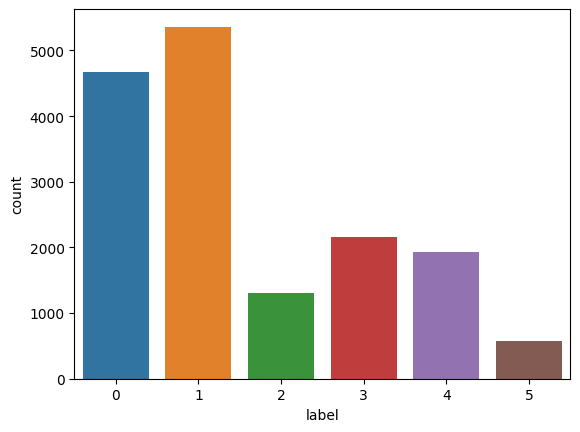

In [4]:
#label distribution for train split
sns.countplot(x=train_df['label'])

<AxesSubplot: xlabel='label', ylabel='count'>

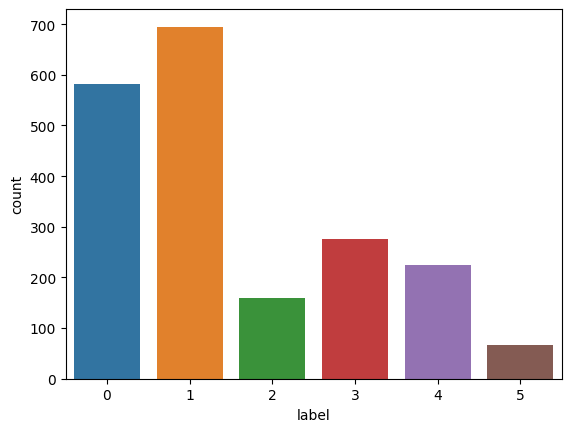

In [5]:
#label distribution for test split
sns.countplot(x=test_df['label'])

In [6]:
#helper function
def clean_tweets_without_nlp(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([ word for word in words])
    return tweet

def clean_tweets_with_stem(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([word for word in words if word not in stopwords.words('english') ])
    words = word_tokenize(tweet)
    porter = PorterStemmer()
    tweet = " ".join([ porter.stem(word) for word in words])
    return tweet

def clean_tweets_with_lem(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([word for word in words if word not in stopwords.words('english') ])
    words = word_tokenize(tweet)
    lem = WordNetLemmatizer()
    tweet = " ".join([ lem.lemmatize(word) for word in words])
    return tweet

#apply helper function
train_df['cleaned_text'] = train_df['text'].apply(clean_tweets_without_nlp)
test_df['cleaned_text'] = test_df['text'].apply(clean_tweets_without_nlp)

train_df['cleaned_text_stem'] = train_df['text'].apply(clean_tweets_with_stem)
test_df['cleaned_text_stem'] = test_df['text'].apply(clean_tweets_with_stem)

train_df['cleaned_text_lem'] = train_df['text'].apply(clean_tweets_with_lem)
test_df['cleaned_text_lem'] = test_df['text'].apply(clean_tweets_with_lem)




/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


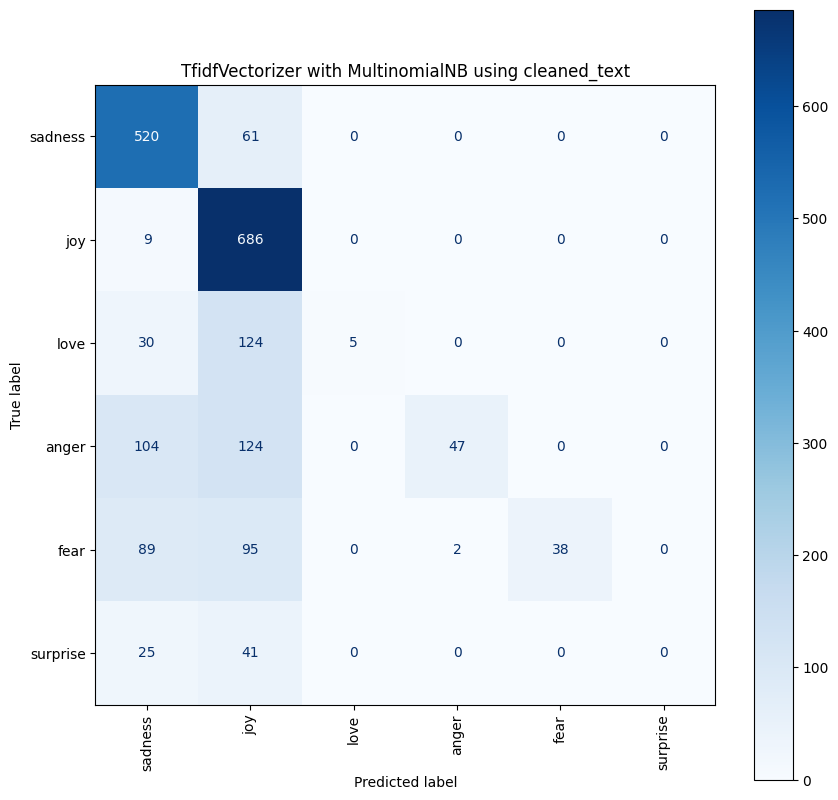

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      0.90      0.77       581
           1       0.61      0.99      0.75       695
           2       1.00      0.03      0.06       159
           3       0.96      0.17      0.29       275
           4       1.00      0.17      0.29       224
           5       0.00      0.00      0.00        66

    accuracy                           0.65      2000
   macro avg       0.71      0.38      0.36      2000
weighted avg       0.73      0.65      0.56      2000



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


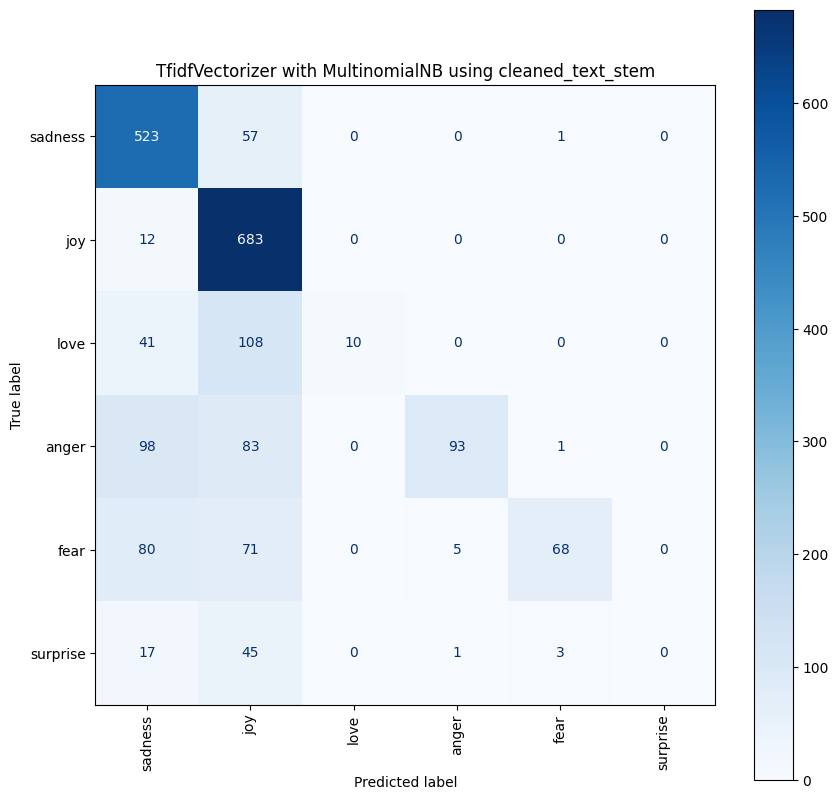

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/util

              precision    recall  f1-score   support

           0       0.68      0.90      0.77       581
           1       0.65      0.98      0.78       695
           2       1.00      0.06      0.12       159
           3       0.94      0.34      0.50       275
           4       0.93      0.30      0.46       224
           5       0.00      0.00      0.00        66

    accuracy                           0.69      2000
   macro avg       0.70      0.43      0.44      2000
weighted avg       0.74      0.69      0.63      2000



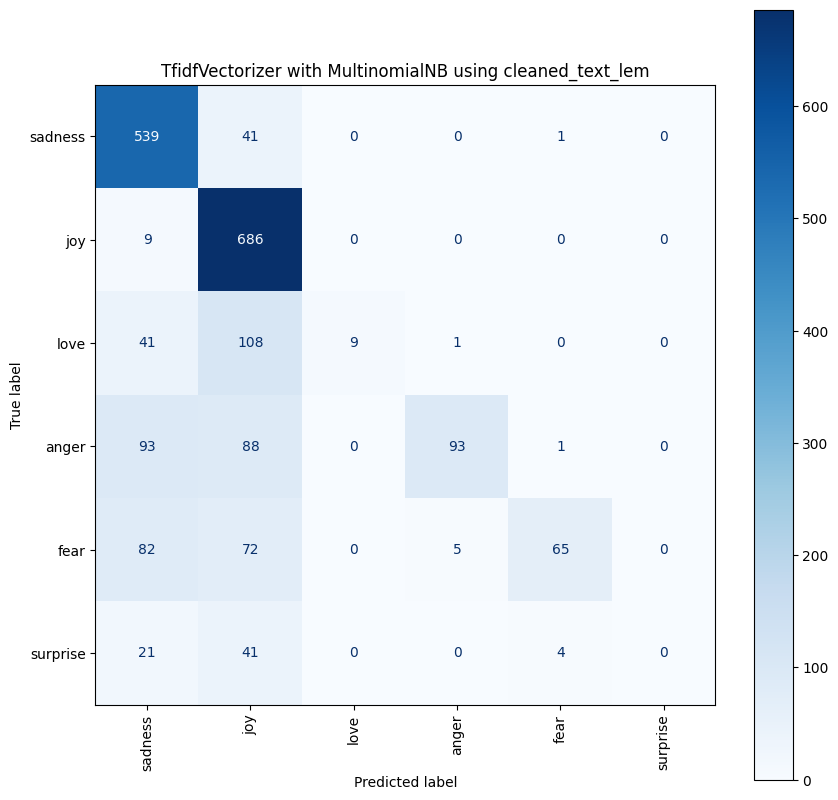

              precision    recall  f1-score   support

           0       0.69      0.93      0.79       581
           1       0.66      0.99      0.79       695
           2       1.00      0.06      0.11       159
           3       0.94      0.34      0.50       275
           4       0.92      0.29      0.44       224
           5       0.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.70      0.43      0.44      2000
weighted avg       0.74      0.70      0.63      2000



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Tfid Vectorized MNB Model

tfid_models = []

for col in train_df.columns[2:]:

    #split features and label
    X_train = train_df[col]
    y_train = train_df['label']

    X_test = test_df[col]
    y_test = test_df['label']

    #Fit and Transform
    X_temp = pd.concat([X_train,X_test])
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X_temp)

    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)

    #Create model and predict
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Create confusion matrix for Tfid model
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, X_test, y_test, display_labels=['sadness','joy','love','anger','fear','surprise'], cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=90)
    plt.title(f'TfidfVectorizer with MultinomialNB using {col}')
    plt.show()

    # display metrics
    # metrics_df = {
    #     'precision_score' : precision_score(y_test, y_pred, average=None),
    #     'recall_score' : recall_score(y_test, y_pred, average=None),
    #     'f1_score' : f1_score(y_test, y_pred, average=None)
    # }

    # display(pd.DataFrame(metrics_df, index=['sadness','joy','love','anger','fear','surprise']))

    print(classification_report(y_test, model.predict(X_test)))

    package = [model, tfidf_vectorizer]
    tfid_models.append(model)

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


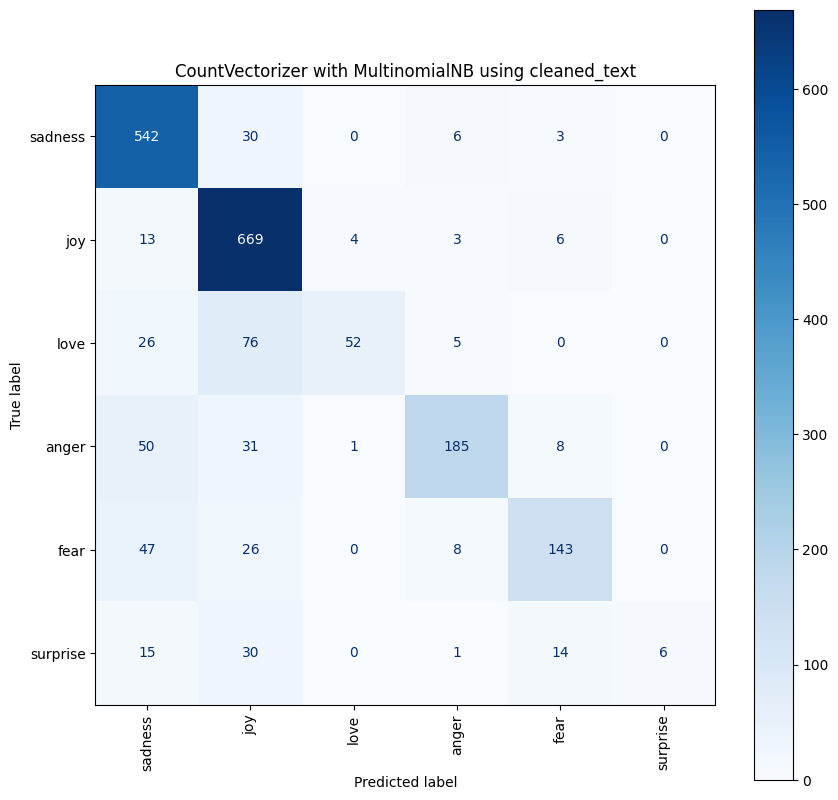

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       581
           1       0.78      0.96      0.86       695
           2       0.91      0.33      0.48       159
           3       0.89      0.67      0.77       275
           4       0.82      0.64      0.72       224
           5       1.00      0.09      0.17        66

    accuracy                           0.80      2000
   macro avg       0.86      0.60      0.64      2000
weighted avg       0.82      0.80      0.78      2000



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


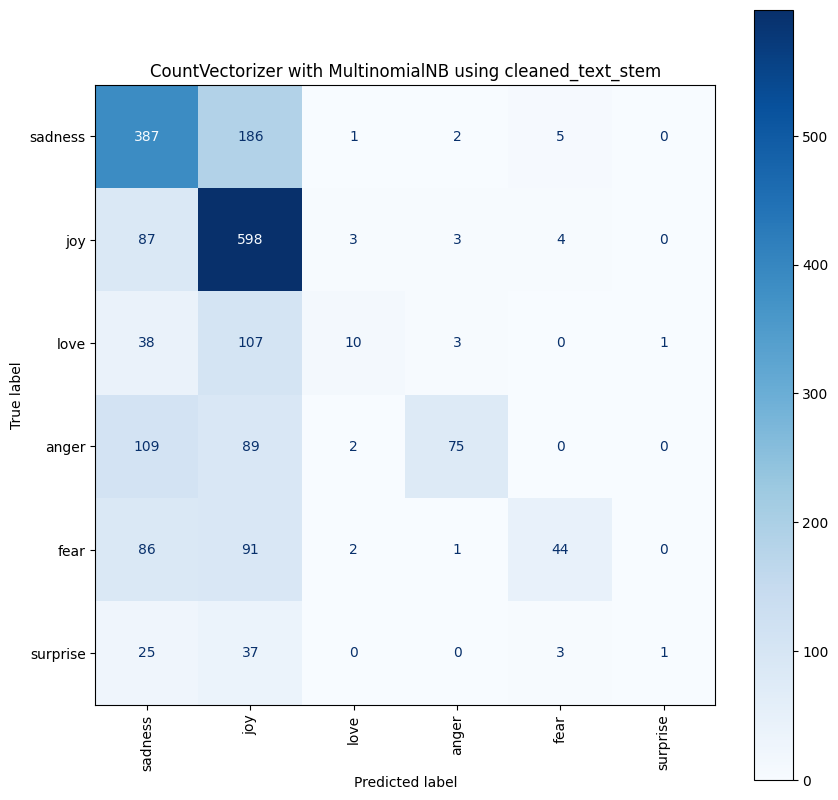

              precision    recall  f1-score   support

           0       0.53      0.67      0.59       581
           1       0.54      0.86      0.66       695
           2       0.56      0.06      0.11       159
           3       0.89      0.27      0.42       275
           4       0.79      0.20      0.31       224
           5       0.50      0.02      0.03        66

    accuracy                           0.56      2000
   macro avg       0.63      0.35      0.35      2000
weighted avg       0.61      0.56      0.50      2000



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


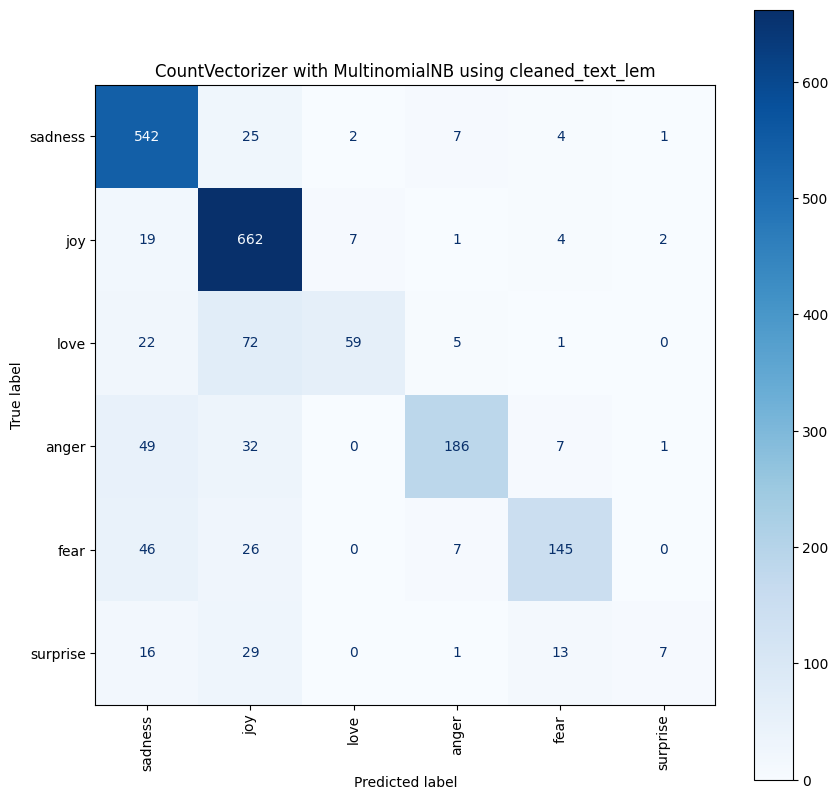

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       581
           1       0.78      0.95      0.86       695
           2       0.87      0.37      0.52       159
           3       0.90      0.68      0.77       275
           4       0.83      0.65      0.73       224
           5       0.64      0.11      0.18        66

    accuracy                           0.80      2000
   macro avg       0.80      0.61      0.65      2000
weighted avg       0.81      0.80      0.78      2000



In [8]:
#Bag of Words with MultinomialNB Model

BoW_models = []

for col in train_df.columns[2:]:

    #split features and label
    X_train = train_df[col]
    y_train = train_df['label']

    X_test = test_df[col]
    y_test = test_df['label']

    #Fit and Transform
    BoW_vectorizer = CountVectorizer()
    BoW_vectorizer.fit(X_temp)

    X_train = BoW_vectorizer.transform(X_train)
    X_test = BoW_vectorizer.transform(X_test)

    #Create model and predict
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Create confusion matrix for BOW model
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, X_test, y_test, display_labels=['sadness','joy','love','anger','fear','surprise'], cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=90)
    plt.title(f'CountVectorizer with MultinomialNB using {col}')
    plt.show()

    #display metrics
    print(classification_report(y_test, model.predict(X_test)))

    package = [model, BoW_vectorizer]
    BoW_models.append(package)

<AxesSubplot: xlabel='label', ylabel='count'>

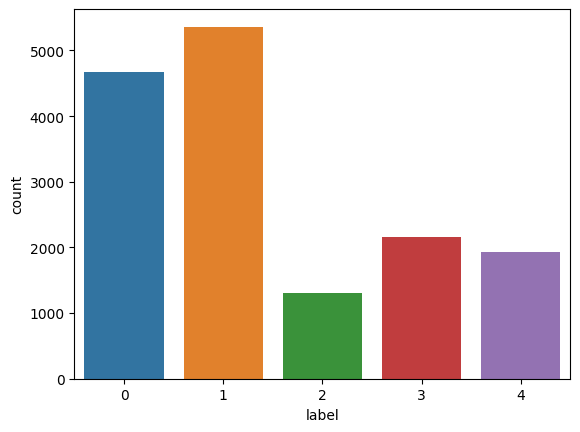

In [9]:
train_df_ = train_df.copy()
test_df_ = test_df.copy()

train_df_ = train_df_[train_df_['label'] != 5]
test_df_ = test_df_[test_df_['label'] != 5]

sns.countplot(x=train_df_['label'])

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


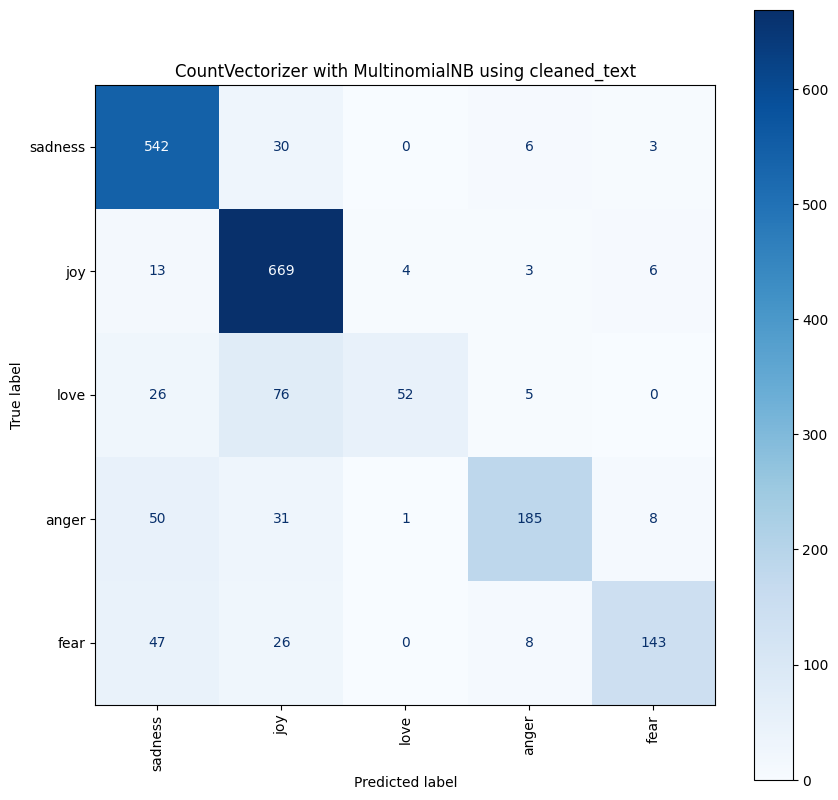

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       581
           1       0.80      0.96      0.88       695
           2       0.91      0.33      0.48       159
           3       0.89      0.67      0.77       275
           4       0.89      0.64      0.74       224

    accuracy                           0.82      1934
   macro avg       0.86      0.71      0.75      1934
weighted avg       0.83      0.82      0.81      1934



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


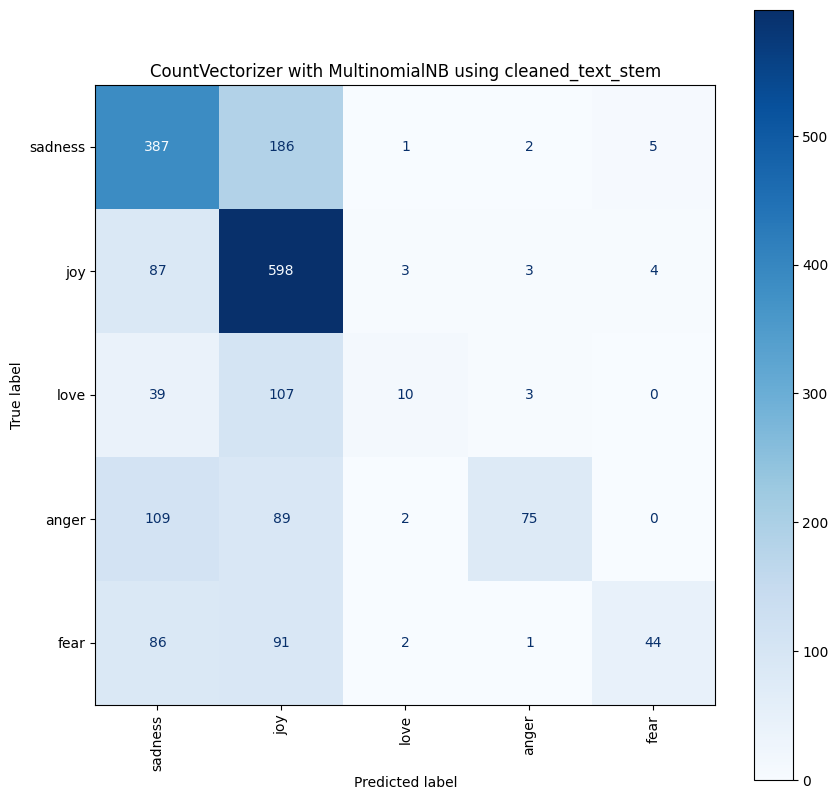

              precision    recall  f1-score   support

           0       0.55      0.67      0.60       581
           1       0.56      0.86      0.68       695
           2       0.56      0.06      0.11       159
           3       0.89      0.27      0.42       275
           4       0.83      0.20      0.32       224

    accuracy                           0.58      1934
   macro avg       0.68      0.41      0.43      1934
weighted avg       0.63      0.58      0.53      1934



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


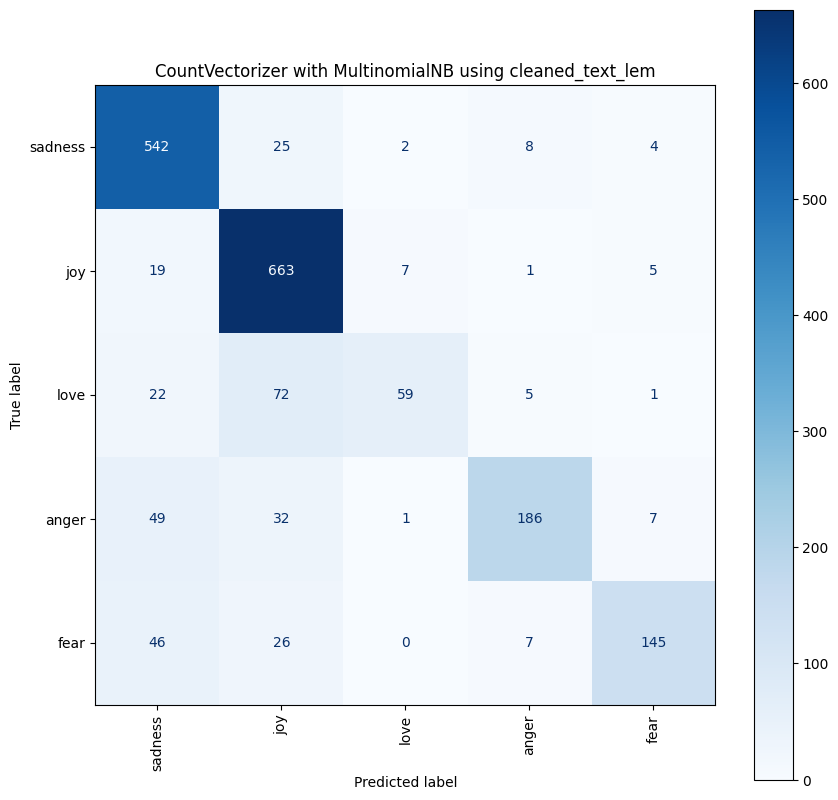

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       581
           1       0.81      0.95      0.88       695
           2       0.86      0.37      0.52       159
           3       0.90      0.68      0.77       275
           4       0.90      0.65      0.75       224

    accuracy                           0.82      1934
   macro avg       0.85      0.72      0.76      1934
weighted avg       0.83      0.82      0.81      1934



In [10]:
#Best Model with label 5 dropped

test_models = []

for col in train_df.columns[2:]:

    #split features and label
    X_train_ = train_df_[col]
    y_train_ = train_df_['label']

    X_test_ = test_df_[col]
    y_test_ = test_df_['label']

    #Fit and Transform
    BoW_vectorizer = CountVectorizer()
    BoW_vectorizer.fit(X_temp)

    X_train_ = BoW_vectorizer.transform(X_train_)
    X_test_ = BoW_vectorizer.transform(X_test_)

    #Create model and predict
    model = MultinomialNB()
    model.fit(X_train_, y_train_)
    y_pred_ = model.predict(X_test_)

    #Create confusion matrix for BOW model
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, X_test_, y_test_, display_labels=['sadness','joy','love','anger','fear'], cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=90)
    plt.title(f'CountVectorizer with MultinomialNB using {col}')
    plt.show()

    #display metrics
    print(classification_report(y_test_, model.predict(X_test_)))

    package = [model, BoW_vectorizer]
    test_models.append(package)

In [12]:
print(classification_report(y_test, BoW_models[0][0].predict(X_test)))
print(classification_report(y_test_, test_models[0][0].predict(X_test_)))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86       581
           1       0.78      0.95      0.86       695
           2       0.84      0.37      0.52       159
           3       0.89      0.71      0.79       275
           4       0.82      0.66      0.73       224
           5       0.73      0.12      0.21        66

    accuracy                           0.80      2000
   macro avg       0.81      0.62      0.66      2000
weighted avg       0.81      0.80      0.78      2000

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       581
           1       0.81      0.95      0.87       695
           2       0.83      0.37      0.51       159
           3       0.89      0.71      0.79       275
           4       0.89      0.66      0.75       224

    accuracy                           0.83      1934
   macro avg       0.85      0.72      0.76      1934
weighted avg       0.83

In [ ]:
#Bag of Words Model with Special Character as Features #! Emojis Unicode with Regex, ! , text-based emoji 🚀 :) :-)

In [ ]:
# save best model 
# pickle.dump(BoW_models[0][0], open('cleaned_BoW-MNB.pkl', 'wb'))

# save vectorizer
# pickle.dump(BoW_models[0][1], open('BoW_vectorizer-MNB.pkl', 'wb'))